# Imports

In [15]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import pandas as pd
import numpy as np

import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras import regularizers
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load Data

In [16]:
data = pd.read_csv("data/data_cleaned.csv")

# Data Preparation

In [17]:
# one hot
data = pd.get_dummies(data, prefix = ["HEAT", "AC", "STYLE", "STRUCT", "GRADE", "CNDTN", "EXTWALL", "INTWALL", "ROOF", "ASSESSMENT_SUBNBHD"], columns = ["HEAT", "AC", "STYLE", "STRUCT", "GRADE", "CNDTN", "EXTWALL", "INTWALL", "ROOF", "ASSESSMENT_SUBNBHD"])

In [18]:
# split
x_data = data.drop(["PRICE"], axis=1)
y_data = data["PRICE"]

In [19]:
# normalization
x_data = x_data.astype(float)
x_data = x_data.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [20]:
# train & test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

# NN

In [21]:
model = Sequential()
model.add(Dense(256, activation="tanh", kernel_initializer='normal', input_shape=(247,)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(512, activation="relu", kernel_initializer='normal'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(512, activation="relu", kernel_initializer='normal'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(512, activation="relu", kernel_initializer='normal', 
    kernel_regularizer=regularizers.l1(0.02), bias_regularizer=regularizers.l1(0.02)))
model.add(Dropout(0.4))
model.add(Dense(512, activation="relu", kernel_initializer='normal', 
    kernel_regularizer=regularizers.l1_l2(0.02), bias_regularizer=regularizers.l1_l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(256, activation="relu", kernel_initializer='normal'))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(
    loss='mean_squared_error',
    optimizer='nadam',
    metrics=["mae"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               63488     
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
__________

In [22]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint(filepath='./weights.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(x_train, 
          y_train,
          batch_size = 128,
          shuffle = True,
          epochs = 200,
          validation_data = (x_test, y_test),
          callbacks=[es, mc])

Train on 40115 samples, validate on 19759 samples
Epoch 1/200
40115/40115 [==============================] - 28s 689us/step - loss: 132600457154.1745 - mean_absolute_error: 211787.1920 - val_loss: 75296434681.0814 - val_mean_absolute_error: 189956.7062

Epoch 00001: val_loss improved from inf to 75296434681.08144, saving model to ./weights.hdf5
Epoch 2/200
40115/40115 [==============================] - 25s 635us/step - loss: 85350355318.1180 - mean_absolute_error: 163017.0882 - val_loss: 54936205731.9856 - val_mean_absolute_error: 139952.6024

Epoch 00002: val_loss improved from 75296434681.08144 to 54936205731.98563, saving model to ./weights.hdf5
Epoch 3/200
40115/40115 [==============================] - 25s 621us/step - loss: 77837982862.6172 - mean_absolute_error: 158093.9023 - val_loss: 42760611860.1079 - val_mean_absolute_error: 132609.2639

Epoch 00003: val_loss improved from 54936205731.98563 to 42760611860.10790, saving model to ./weights.hdf5
Epoch 4/200
40115/40115 [========

40115/40115 [==============================] - 24s 601us/step - loss: 44008473547.3896 - mean_absolute_error: 133559.6234 - val_loss: 36794785246.1327 - val_mean_absolute_error: 112887.5857

Epoch 00030: val_loss did not improve from 34944113804.80713
Epoch 31/200
40115/40115 [==============================] - 24s 609us/step - loss: 44938941821.2910 - mean_absolute_error: 133173.4370 - val_loss: 36278158887.6716 - val_mean_absolute_error: 112766.6063

Epoch 00031: val_loss did not improve from 34944113804.80713
Epoch 32/200
40115/40115 [==============================] - 24s 598us/step - loss: 43382596338.5666 - mean_absolute_error: 131787.6924 - val_loss: 37103970295.0862 - val_mean_absolute_error: 118115.372398 - mean_absolute_

Epoch 00032: val_loss did not improve from 34944113804.80713
Epoch 33/200
40115/40115 [==============================] - 24s 596us/step - loss: 43384920181.0650 - mean_absolute_error: 132227.8853 - val_loss: 35490958778.8402 - val_mean_absolute_error: 115504.9

In [23]:
model.load_weights('./weights.hdf5')

train_score = model.evaluate(x_train, y_train, verbose=0)
valid_score = model.evaluate(x_test, y_test, verbose=0)

y_pred = model.predict(x_test)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train MAE:  101812.7635 , Train Loss:  39911070903.7
Val MAE:  108280.1768 , Val Loss:  32342354649.7


In [24]:
r2_score(y_test, y_pred)

0.84362095950000282

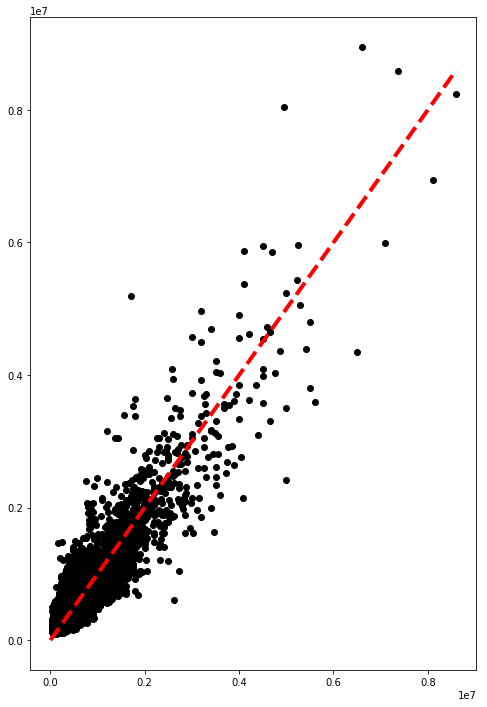

In [25]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, c='black')
ax.plot([0, y_test.max()], [0, y_test.max()], "r--", lw=4)
plt.show()

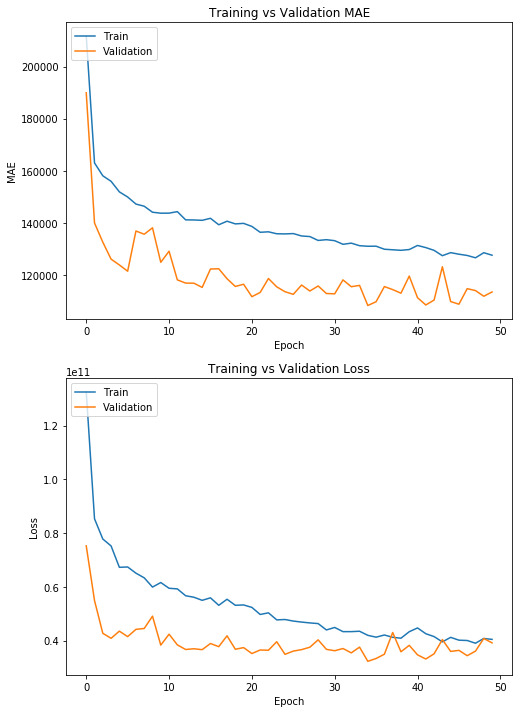

In [26]:
def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return

plot_hist(history.history, xsize=8, ysize=12) 